Author: Haotian Tan  
Final Checked by Oct. 8th, 2025

Note that running the Mantel test with 100,000 permutations will take approximately 20 minutes.

In [ ]:
import numpy as np
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

def safe_zscore(arr, axis=0, ddof=1):
    mean = np.nanmean(arr, axis=axis, keepdims=True)
    std = np.nanstd(arr, axis=axis, ddof=ddof, keepdims=True)
    std[std == 0] = np.nan   
    return (arr - mean) / std

def compute_multivariable_rdm(df_subset, variables, subject_order=None):

    if subject_order is None:
        subjects = sorted(df_subset['id'].unique())
    else:
        subjects = subject_order

    cond_vectors = []
    for var in variables:
        mat = df_subset.pivot_table(index="id", columns=["Unfairness", "Cost"], values=var)
        mat = mat.reindex(subjects)

        mat_values = mat.T.values  # (n_conditions, n_subjects)
        mat_values = safe_zscore(mat_values, axis=1, ddof=1)
        cond_vectors.append(mat_values)

    cond_matrix = np.concatenate(cond_vectors, axis=1)
    rdm = squareform(pdist(cond_matrix, metric="correlation"))

    return rdm


def mantel_test(rdm1, rdm2, perms=100000, seed=42):

    idx = np.triu_indices_from(rdm1, k=1)
    x = rdm1[idx]
    y = rdm2[idx]

    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    if len(x) == 0:
        return np.nan, np.nan
    r_orig = np.corrcoef(x, y)[0, 1]

    perm_r = np.zeros(perms)
    for i in range(perms):
        permuted = np.random.permutation(y)
        perm_r[i] = np.corrcoef(x, permuted)[0, 1]

    p_value = (np.sum(perm_r >= r_orig) + 1) / (perms + 1)
    return r_orig, p_value

def print_mantel_results(group_condition_rdms, variables, perms=100000):
    print(f'Mantel test results of {variables}')
    
    for (g1, c1), (g2, c2) in combinations(group_condition_rdms.keys(), 2):
        r, p = mantel_test(group_condition_rdms[(g1, c1)], group_condition_rdms[(g2, c2)], perms=perms)
        
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else:
            sig = ''
        
        print(f'{g1}/{c1} vs {g2}/{c2}: r = {r:.3f}, p = {p:.3e} {sig}')

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_and_compute_rdms(df, variables, groups_order, conditions, svg_filename="RDM_plot.svg"):

    group_condition_rdms = {}
    plot_index = 0

    fig = plt.figure(figsize=(25, 10))
    gs = GridSpec(2, 5, figure=fig, height_ratios=[1,1], width_ratios=[2,1,1,1,1])

    # Figure of Human
    g = 'Human'
    g_df = df[df['group'] == g]
    rdm = compute_multivariable_rdm(g_df, variables)
    group_condition_rdms[(g, 'baseline')] = rdm

    ax_human = fig.add_subplot(gs[0:2, 0])
    im = ax_human.imshow(rdm, cmap='viridis', vmin=0, vmax=2)
    n = rdm.shape[0]
    tick_positions = np.arange(0, n, 10)
    tick_labels = tick_positions + 1
    ax_human.set_xticks(tick_positions)
    ax_human.set_yticks(tick_positions)
    ax_human.set_xticklabels(tick_labels, fontsize=7)
    ax_human.set_yticklabels(tick_labels, fontsize=7)
    ax_human.invert_yaxis()
    ax_human.set_title(f'{g}, Baseline', fontsize=12)
    ax_human.text(0, 1.07, f'{chr(97 + plot_index)}', transform=ax_human.transAxes,
                  fontsize=14, fontweight='bold', va='top', ha='right')
    plot_index += 1

    # Allocation and Cost Condition
    allocation_labels = ['15-15','16-14','17-13','18-12','19-11','20-10']
    allocation_positions = [pos + 5 for pos in range(0, 60, 10)]
    for pos, label in zip(allocation_positions, allocation_labels):
        ax_human.text(pos, -0.05, f'Allocation:\n {label}', ha='center', va='top', fontsize=11, rotation=0, transform=ax_human.get_xaxis_transform())
    ax_human.text(5, -0.13, 'Cost: 0→9', ha='center', va='top', fontsize=11, transform=ax_human.get_xaxis_transform())

    # Figure of LLMs

    for row_idx, cond in enumerate(conditions):
        for col_idx, g in enumerate(groups_order[1:], start=1):
            g_df = df[(df['group'] == g) & (df['condition'] == cond)]
            rdm = compute_multivariable_rdm(g_df, variables)
            group_condition_rdms[(g, cond)] = rdm

            ax = fig.add_subplot(gs[row_idx, col_idx])
            im = ax.imshow(rdm, cmap='viridis', vmin=0, vmax=2)
            n = rdm.shape[0]
            tick_positions = np.arange(0, n, 10)
            tick_labels = tick_positions + 1
            ax.set_xticks(tick_positions)
            ax.set_yticks(tick_positions)
            ax.set_xticklabels(tick_labels, fontsize=7)
            ax.set_yticklabels(tick_labels, fontsize=7)
            ax.invert_yaxis()
            ax.set_title(f'{g}, {cond}', fontsize=12)
            ax.text(0, 1.07, f'{chr(97 + plot_index)}', transform=ax.transAxes,
                    fontsize=14, fontweight='bold', va='top', ha='right')
            plot_index += 1

    # colorbar
    cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('correlation distance (1 - r)', fontsize=12)

    # save SVG
    fig.savefig(svg_filename, format="svg",bbox_inches='tight')
    plt.show()

    return group_condition_rdms

In [3]:
import pandas as pd

df_no = pd.read_csv("merged_all_models_nopersona.csv")
df_yes = pd.read_csv("merged_all_models_persona.csv")

df_no["condition"] = "nopersona"
df_yes["condition"] = "persona"

cols = [
    "id", "group", "amount_of_allocation", "amount_of_cost", "choice",
    "AA_valence", "AA_arousal", "AC_valence", "AC_arousal", "condition"
]

df_all = pd.concat([df_no[cols], df_yes[cols]], ignore_index=True)

df_all["Cost"] = df_all["amount_of_cost"]
df_all["Unfairness"] = 30 - 2*df_all["amount_of_allocation"]

df = df_all.sort_values(by=["Unfairness", "Cost"], ascending=[True, True]).reset_index(drop=True)

supplementary table 6.2.1

# ALL variables

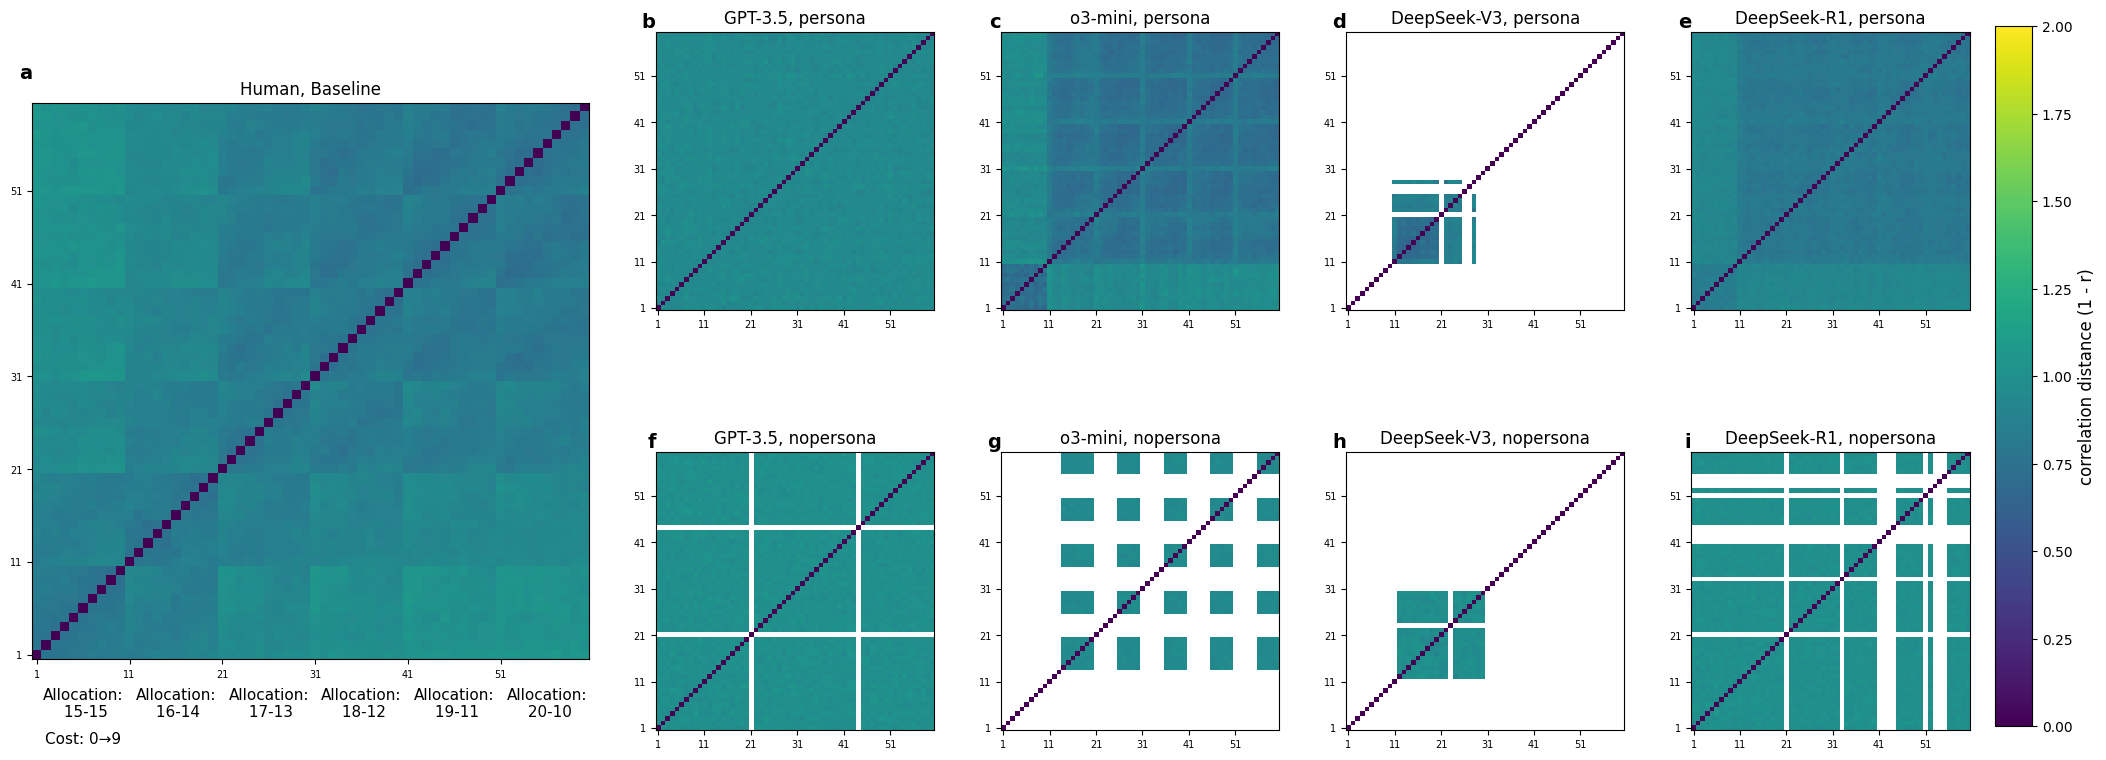

Mantel test results of ['choice', 'AA_valence', 'AC_valence', 'AC_valence', 'AC_arousal']
Human/baseline vs GPT-3.5/persona: r = 0.176, p = 1.000e-05 ***
Human/baseline vs o3-mini/persona: r = 0.745, p = 1.000e-05 ***
Human/baseline vs DeepSeek-V3/persona: r = 0.513, p = 1.000e-05 ***
Human/baseline vs DeepSeek-R1/persona: r = 0.645, p = 1.000e-05 ***
Human/baseline vs GPT-3.5/nopersona: r = -0.041, p = 9.533e-01 
Human/baseline vs o3-mini/nopersona: r = 0.003, p = 4.735e-01 
Human/baseline vs DeepSeek-V3/nopersona: r = -0.006, p = 5.311e-01 
Human/baseline vs DeepSeek-R1/nopersona: r = 0.043, p = 6.330e-02 
GPT-3.5/persona vs o3-mini/persona: r = 0.178, p = 1.000e-05 ***
GPT-3.5/persona vs DeepSeek-V3/persona: r = 0.038, p = 3.547e-01 
GPT-3.5/persona vs DeepSeek-R1/persona: r = 0.180, p = 1.000e-05 ***
GPT-3.5/persona vs GPT-3.5/nopersona: r = -0.025, p = 8.474e-01 
GPT-3.5/persona vs o3-mini/nopersona: r = 0.010, p = 4.222e-01 
GPT-3.5/persona vs DeepSeek-V3/nopersona: r = 0.062, p 

In [4]:
from itertools import combinations

groups_order = ['Human', 'GPT-3.5', 'o3-mini', 'DeepSeek-V3', 'DeepSeek-R1']
conditions = ['persona', 'nopersona']
variables = ['choice','AA_valence','AC_valence','AC_valence','AC_arousal']

group_condition_rdms = plot_and_compute_rdms(df, variables, groups_order, conditions, svg_filename = "RSA_Combined Variables.svg")

print_mantel_results(group_condition_rdms, variables=variables)

# Choice

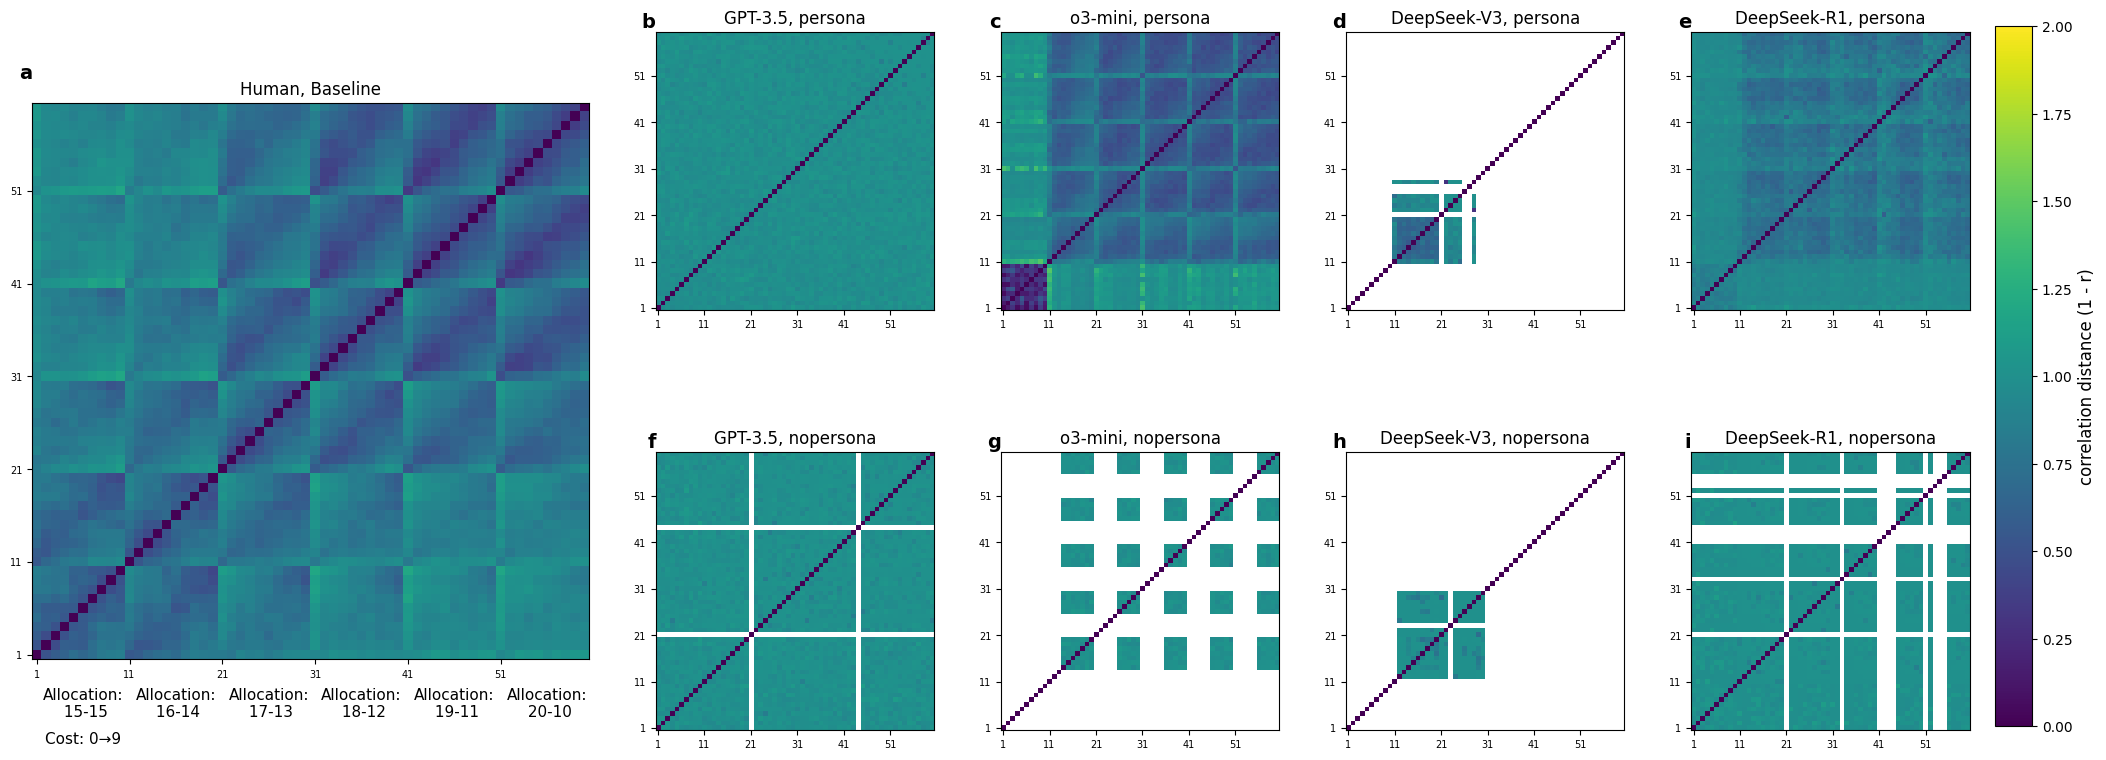

Mantel test results of ['choice']
Human/baseline vs GPT-3.5/persona: r = 0.043, p = 3.446e-02 *
Human/baseline vs o3-mini/persona: r = 0.649, p = 1.000e-05 ***
Human/baseline vs DeepSeek-V3/persona: r = 0.263, p = 3.590e-03 **
Human/baseline vs DeepSeek-R1/persona: r = 0.411, p = 1.000e-05 ***
Human/baseline vs GPT-3.5/nopersona: r = -0.003, p = 5.465e-01 
Human/baseline vs o3-mini/nopersona: r = 0.031, p = 2.817e-01 
Human/baseline vs DeepSeek-V3/nopersona: r = 0.085, p = 1.460e-01 
Human/baseline vs DeepSeek-R1/nopersona: r = 0.063, p = 1.443e-02 *
GPT-3.5/persona vs o3-mini/persona: r = 0.020, p = 1.990e-01 
GPT-3.5/persona vs DeepSeek-V3/persona: r = 0.012, p = 4.556e-01 
GPT-3.5/persona vs DeepSeek-R1/persona: r = -0.045, p = 9.712e-01 
GPT-3.5/persona vs GPT-3.5/nopersona: r = -0.011, p = 6.660e-01 
GPT-3.5/persona vs o3-mini/nopersona: r = 0.070, p = 9.419e-02 
GPT-3.5/persona vs DeepSeek-V3/nopersona: r = 0.007, p = 4.645e-01 
GPT-3.5/persona vs DeepSeek-R1/nopersona: r = -0.01

In [5]:
from itertools import combinations

groups_order = ['Human', 'GPT-3.5', 'o3-mini', 'DeepSeek-V3', 'DeepSeek-R1']
conditions = ['persona', 'nopersona']
variables = ['choice']

group_condition_rdms = plot_and_compute_rdms(df, variables, groups_order, conditions, svg_filename = "RSA_Choice.svg")


print_mantel_results(group_condition_rdms, variables=variables)


# Emotional valence after allocation

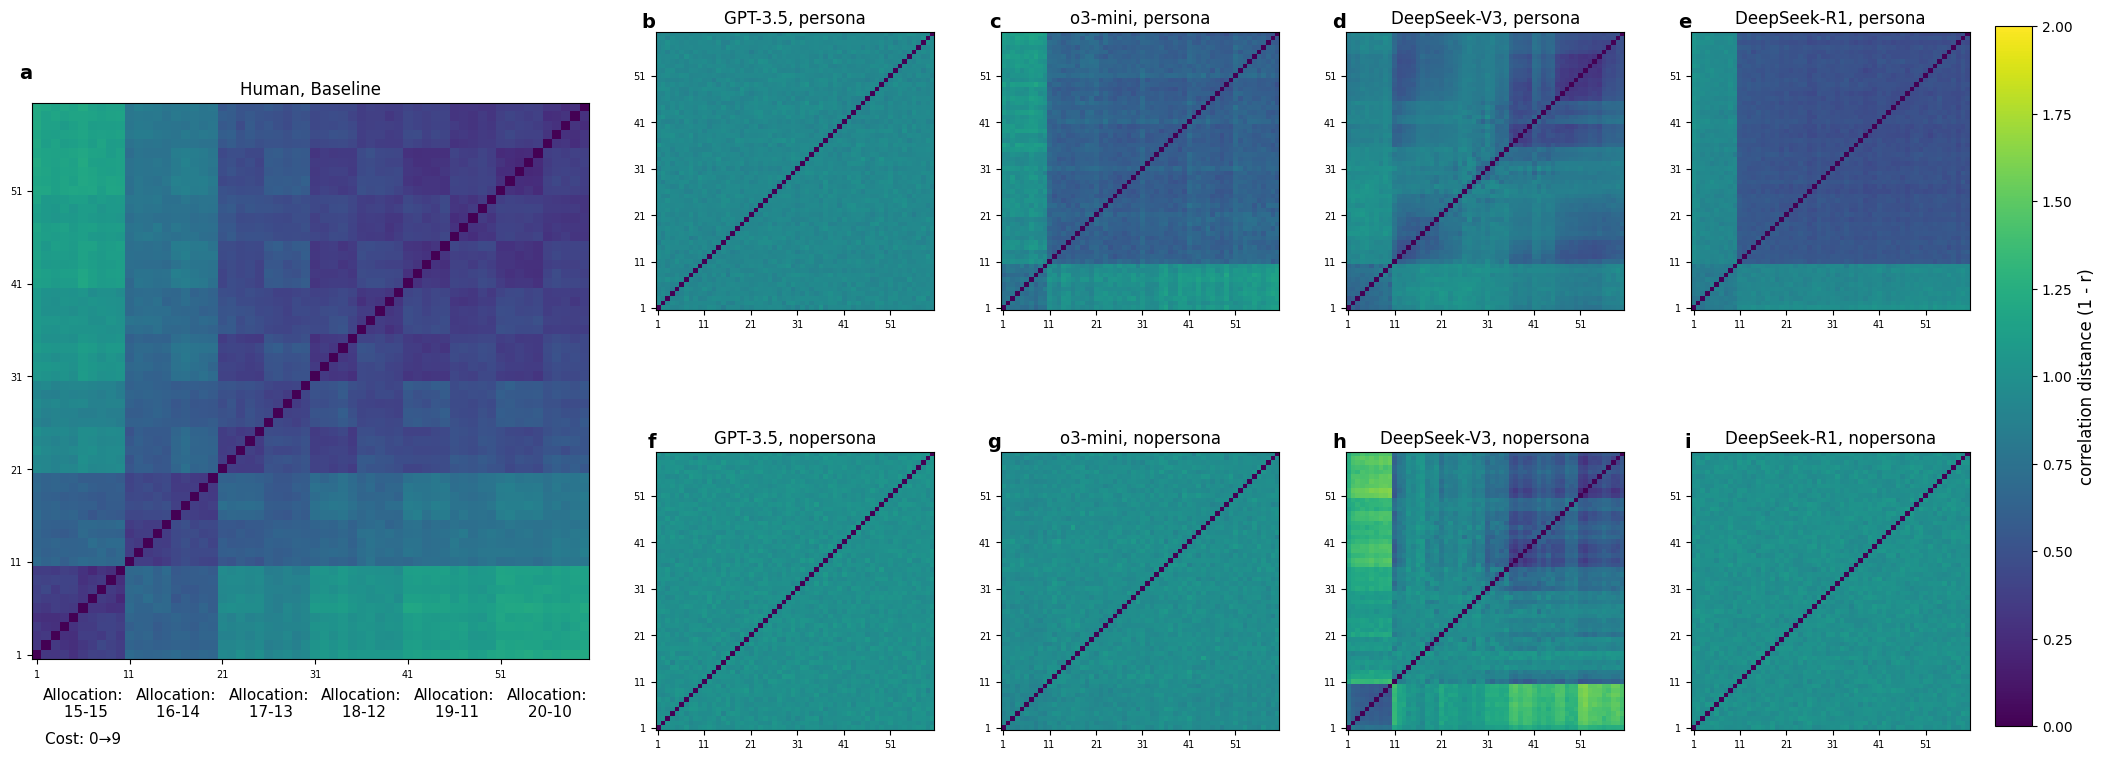

Mantel test results of ['AA_valence']
Human/baseline vs GPT-3.5/persona: r = 0.051, p = 1.549e-02 *
Human/baseline vs o3-mini/persona: r = 0.798, p = 1.000e-05 ***
Human/baseline vs DeepSeek-V3/persona: r = 0.499, p = 1.000e-05 ***
Human/baseline vs DeepSeek-R1/persona: r = 0.759, p = 1.000e-05 ***
Human/baseline vs GPT-3.5/nopersona: r = -0.011, p = 6.752e-01 
Human/baseline vs o3-mini/nopersona: r = -0.148, p = 1.000e+00 
Human/baseline vs DeepSeek-V3/nopersona: r = 0.834, p = 1.000e-05 ***
Human/baseline vs DeepSeek-R1/nopersona: r = -0.009, p = 6.470e-01 
GPT-3.5/persona vs o3-mini/persona: r = 0.019, p = 2.158e-01 
GPT-3.5/persona vs DeepSeek-V3/persona: r = 0.053, p = 1.252e-02 *
GPT-3.5/persona vs DeepSeek-R1/persona: r = 0.010, p = 3.419e-01 
GPT-3.5/persona vs GPT-3.5/nopersona: r = -0.006, p = 6.052e-01 
GPT-3.5/persona vs o3-mini/nopersona: r = -0.031, p = 9.010e-01 
GPT-3.5/persona vs DeepSeek-V3/nopersona: r = 0.064, p = 3.600e-03 **
GPT-3.5/persona vs DeepSeek-R1/noperson

In [6]:
from itertools import combinations

groups_order = ['Human', 'GPT-3.5', 'o3-mini', 'DeepSeek-V3', 'DeepSeek-R1']
conditions = ['persona', 'nopersona']
variables = ['AA_valence']

group_condition_rdms = plot_and_compute_rdms(df, variables, groups_order, conditions, svg_filename = "RSA_valence_after_allocation.svg")


print_mantel_results(group_condition_rdms, variables=variables)


# Emotional arousal after allocation

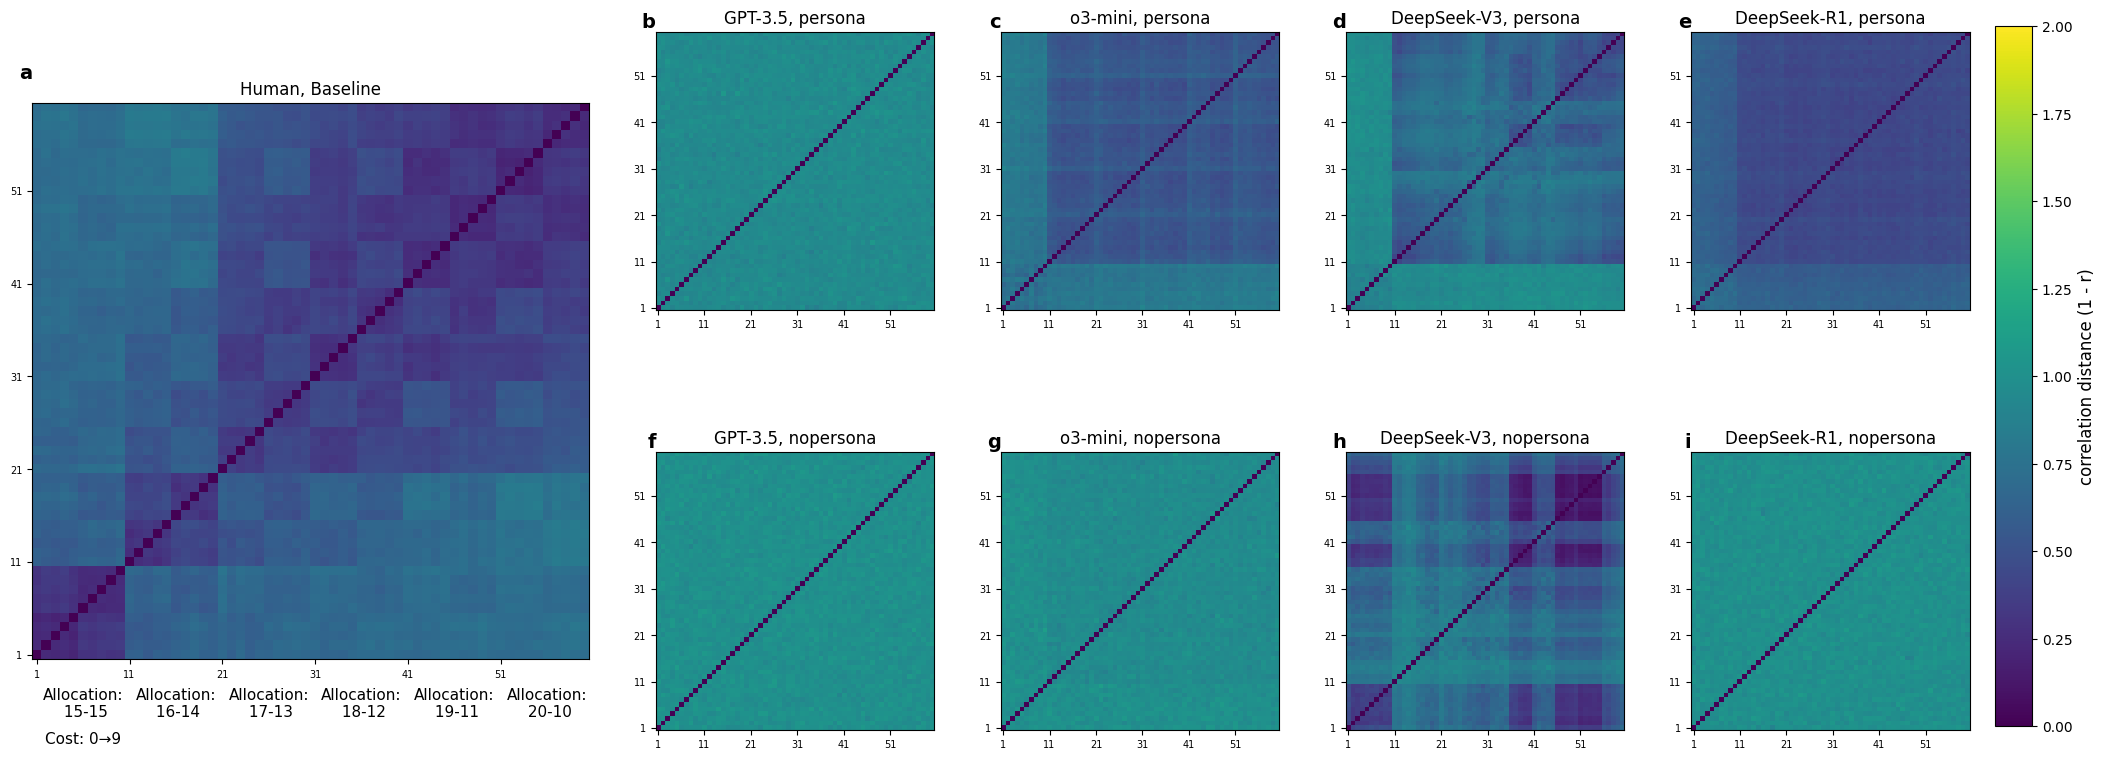

Mantel test results of ['AA_arousal']
Human/baseline vs GPT-3.5/persona: r = -0.018, p = 7.781e-01 
Human/baseline vs o3-mini/persona: r = 0.492, p = 1.000e-05 ***
Human/baseline vs DeepSeek-V3/persona: r = 0.493, p = 1.000e-05 ***
Human/baseline vs DeepSeek-R1/persona: r = 0.422, p = 1.000e-05 ***
Human/baseline vs GPT-3.5/nopersona: r = -0.013, p = 7.100e-01 
Human/baseline vs o3-mini/nopersona: r = 0.244, p = 1.000e-05 ***
Human/baseline vs DeepSeek-V3/nopersona: r = 0.217, p = 1.000e-05 ***
Human/baseline vs DeepSeek-R1/nopersona: r = -0.020, p = 8.044e-01 
GPT-3.5/persona vs o3-mini/persona: r = -0.056, p = 9.909e-01 
GPT-3.5/persona vs DeepSeek-V3/persona: r = -0.050, p = 9.817e-01 
GPT-3.5/persona vs DeepSeek-R1/persona: r = -0.089, p = 9.999e-01 
GPT-3.5/persona vs GPT-3.5/nopersona: r = 0.017, p = 2.349e-01 
GPT-3.5/persona vs o3-mini/nopersona: r = -0.015, p = 7.347e-01 
GPT-3.5/persona vs DeepSeek-V3/nopersona: r = -0.078, p = 9.995e-01 
GPT-3.5/persona vs DeepSeek-R1/nopers

In [7]:
from itertools import combinations

groups_order = ['Human', 'GPT-3.5', 'o3-mini', 'DeepSeek-V3', 'DeepSeek-R1']
conditions = ['persona', 'nopersona']
variables = ['AA_arousal']

group_condition_rdms = plot_and_compute_rdms(df, variables, groups_order, conditions, svg_filename = "RSA_arousal_after_allocation.svg")


print_mantel_results(group_condition_rdms, variables=variables)

# Emotional valence after decision

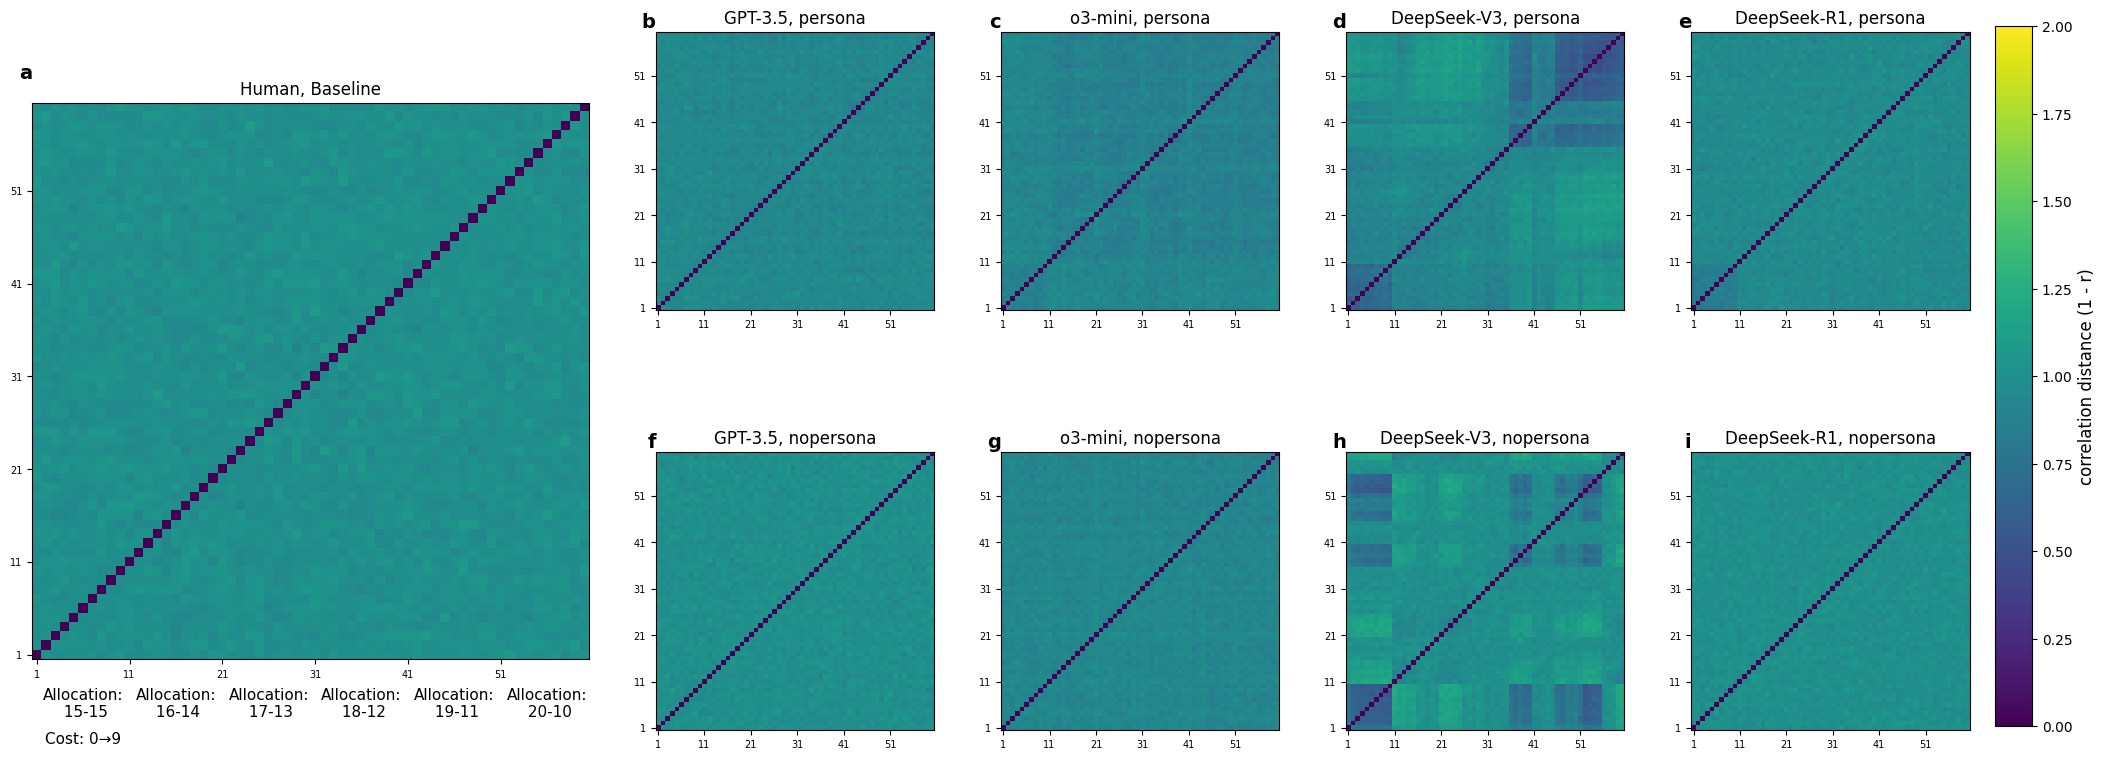

Mantel test results of ['AC_valence']
Human/baseline vs GPT-3.5/persona: r = -0.057, p = 9.922e-01 
Human/baseline vs o3-mini/persona: r = 0.032, p = 8.535e-02 
Human/baseline vs DeepSeek-V3/persona: r = -0.032, p = 9.105e-01 
Human/baseline vs DeepSeek-R1/persona: r = 0.027, p = 1.326e-01 
Human/baseline vs GPT-3.5/nopersona: r = -0.027, p = 8.762e-01 
Human/baseline vs o3-mini/nopersona: r = -0.038, p = 9.425e-01 
Human/baseline vs DeepSeek-V3/nopersona: r = 0.006, p = 4.010e-01 
Human/baseline vs DeepSeek-R1/nopersona: r = 0.011, p = 3.112e-01 
GPT-3.5/persona vs o3-mini/persona: r = 0.114, p = 1.000e-05 ***
GPT-3.5/persona vs DeepSeek-V3/persona: r = 0.011, p = 3.190e-01 
GPT-3.5/persona vs DeepSeek-R1/persona: r = -0.096, p = 1.000e+00 
GPT-3.5/persona vs GPT-3.5/nopersona: r = -0.026, p = 8.616e-01 
GPT-3.5/persona vs o3-mini/nopersona: r = 0.006, p = 4.030e-01 
GPT-3.5/persona vs DeepSeek-V3/nopersona: r = -0.047, p = 9.765e-01 
GPT-3.5/persona vs DeepSeek-R1/nopersona: r = 0.00

In [8]:
from itertools import combinations

groups_order = ['Human', 'GPT-3.5', 'o3-mini', 'DeepSeek-V3', 'DeepSeek-R1']
conditions = ['persona', 'nopersona']
variables = ['AC_valence']

group_condition_rdms = plot_and_compute_rdms(df, variables, groups_order, conditions, svg_filename = "RSA_valence_after_decision.svg")


print_mantel_results(group_condition_rdms, variables=variables)

# Emotional arousal after decision

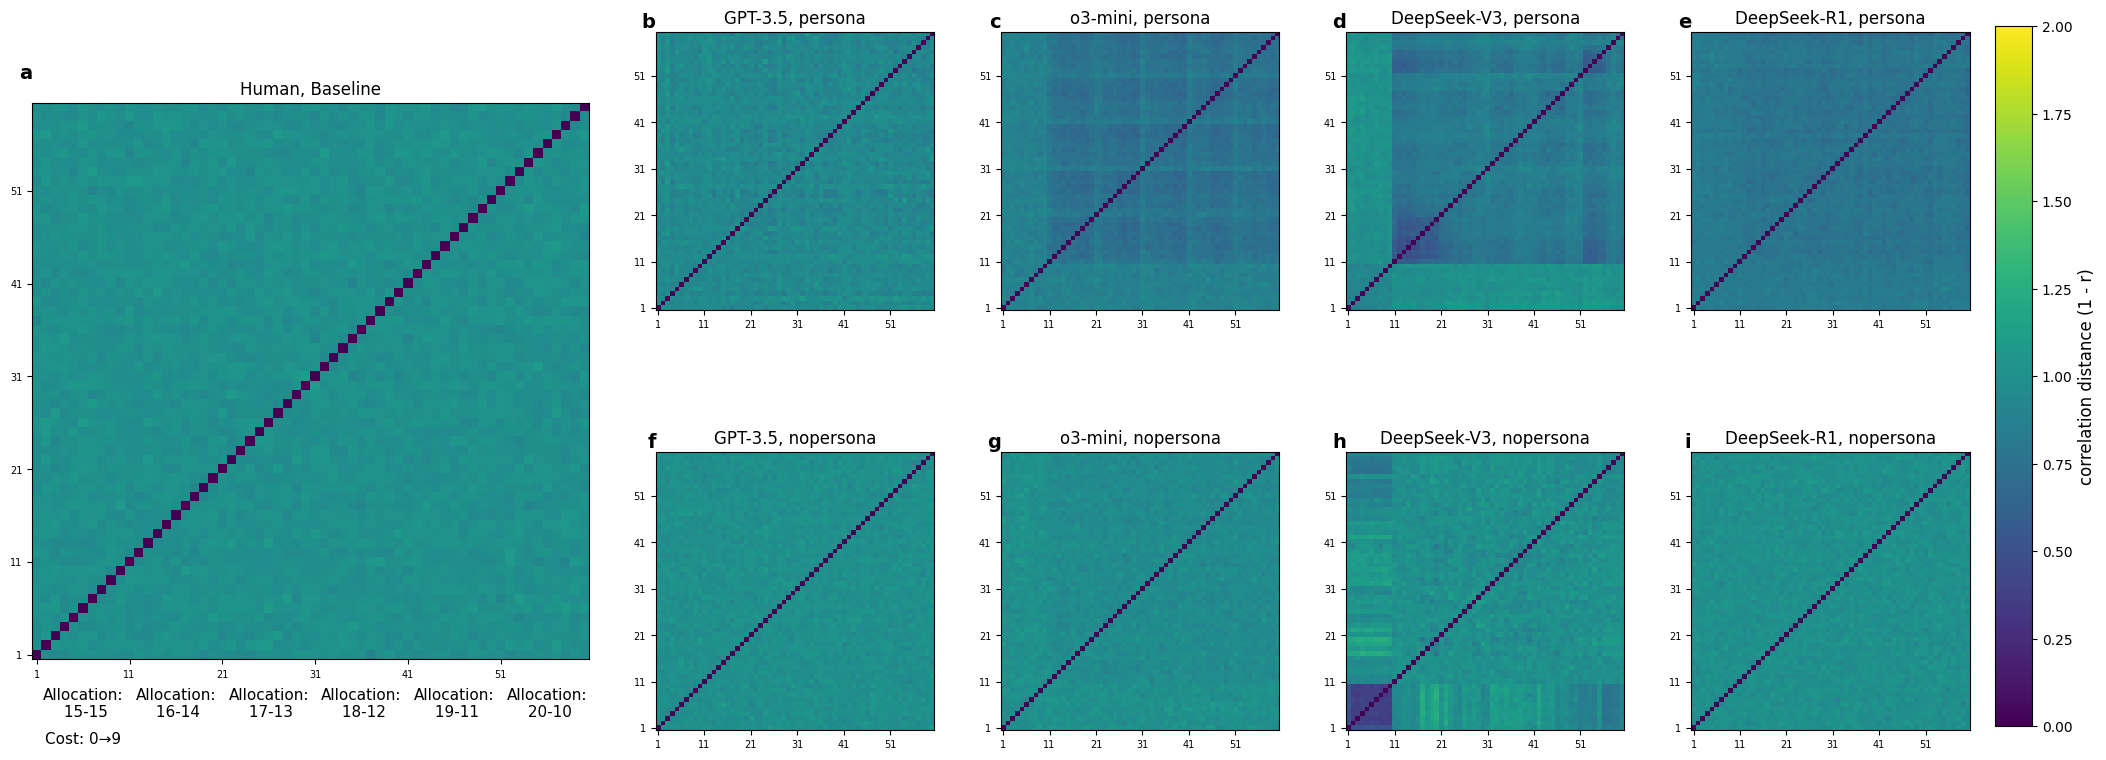

Mantel test results of ['AC_arousal']
Human/baseline vs GPT-3.5/persona: r = -0.029, p = 8.908e-01 
Human/baseline vs o3-mini/persona: r = 0.028, p = 1.231e-01 
Human/baseline vs DeepSeek-V3/persona: r = 0.047, p = 2.424e-02 *
Human/baseline vs DeepSeek-R1/persona: r = -0.014, p = 7.182e-01 
Human/baseline vs GPT-3.5/nopersona: r = -0.051, p = 9.834e-01 
Human/baseline vs o3-mini/nopersona: r = 0.030, p = 1.040e-01 
Human/baseline vs DeepSeek-V3/nopersona: r = -0.006, p = 5.984e-01 
Human/baseline vs DeepSeek-R1/nopersona: r = -0.010, p = 6.548e-01 
GPT-3.5/persona vs o3-mini/persona: r = 0.146, p = 1.000e-05 ***
GPT-3.5/persona vs DeepSeek-V3/persona: r = 0.065, p = 2.920e-03 **
GPT-3.5/persona vs DeepSeek-R1/persona: r = 0.096, p = 4.000e-05 ***
GPT-3.5/persona vs GPT-3.5/nopersona: r = -0.033, p = 9.158e-01 
GPT-3.5/persona vs o3-mini/nopersona: r = 0.092, p = 4.000e-05 ***
GPT-3.5/persona vs DeepSeek-V3/nopersona: r = 0.010, p = 3.434e-01 
GPT-3.5/persona vs DeepSeek-R1/nopersona: 

In [9]:
from itertools import combinations

groups_order = ['Human', 'GPT-3.5', 'o3-mini', 'DeepSeek-V3', 'DeepSeek-R1']
conditions = ['persona', 'nopersona']
variables = ['AC_arousal']

group_condition_rdms = plot_and_compute_rdms(df, variables, groups_order, conditions, svg_filename = "RSA_arousal_after_decision.svg")


print_mantel_results(group_condition_rdms, variables=variables)